This example demonstrate a simple implementation of a Graph Neural Network (GNN) model. The model is used for a node prediction task on the Cora dataset to predict the subject of a paper given its words and citations network.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

2021-12-31 19:12:08.118663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-31 19:12:08.118704: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
citations = pd.read_csv("./data/cora/cora.cites", sep="\t", names=["target", "source"])

In [3]:
citations.shape

(5429, 2)

In [4]:
citations.head()

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [5]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv("./data/cora/cora.content", sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [6]:
papers.columns

Index(['paper_id', 'term_0', 'term_1', 'term_2', 'term_3', 'term_4', 'term_5',
       'term_6', 'term_7', 'term_8',
       ...
       'term_1424', 'term_1425', 'term_1426', 'term_1427', 'term_1428',
       'term_1429', 'term_1430', 'term_1431', 'term_1432', 'subject'],
      dtype='object', length=1435)

In [7]:
papers.subject.unique()

array(['Neural_Networks', 'Rule_Learning', 'Reinforcement_Learning',
       'Probabilistic_Methods', 'Theory', 'Genetic_Algorithms',
       'Case_Based'], dtype=object)

In [8]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

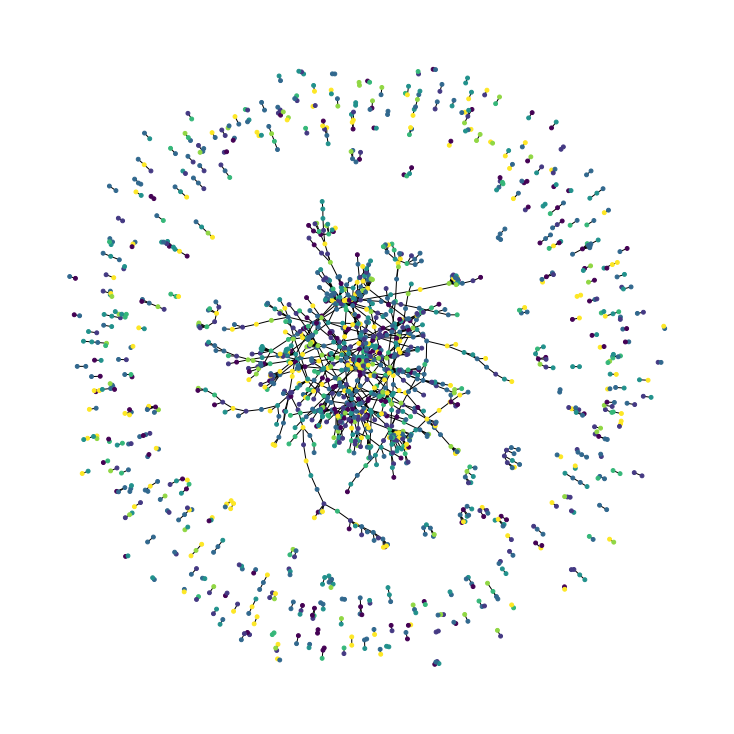

In [9]:
plt.figure(figsize=(10,10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

### Stratified train test split

In [11]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])
    
train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print(train_data.shape, test_data.shape)


(1365, 1435) (1343, 1435)


In [12]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [13]:
def run_experiment(model, x_train, y_train):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
    )
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping]
    )
    return history

def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()    

In [14]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layer = []
    
    for units in hidden_units:
        fnn_layer.append(layers.BatchNormalization())
        fnn_layer.append(layers.Dropout(dropout_rate))
        fnn_layer.append(layers.Dense(units, activation=tf.nn.gelu))
    
    return keras.Sequential(fnn_layer, name=name)

In [15]:
feature_names = set(papers.columns) - {'paper_id', 'subject'}
num_features = len(feature_names)
num_classes = len(class_idx)

x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
y_train = train_data["subject"]
y_test = test_data["subject"]

In [18]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    
    for block_idx in range(4):
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
        
    logits = layers.Dense(num_classes, name="logits")(x)
    return keras.Model(inputs, outputs=logits, name="baseline")

baseline_model=create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           52804       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [19]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 2s 68ms/step - loss: 3.6808 - acc: 0.1655 - val_loss: 1.8901 - val_acc: 0.3171
Epoch 2/300
5/5 [==============================] - 0s 14ms/step - loss: 2.7426 - acc: 0.2612 - val_loss: 1.8770 - val_acc: 0.3317
Epoch 3/300
5/5 [==============================] - 0s 14ms/step - loss: 2.4085 - acc: 0.2310 - val_loss: 1.8587 - val_acc: 0.3512
Epoch 4/300
5/5 [==============================] - 0s 14ms/step - loss: 2.0708 - acc: 0.2672 - val_loss: 1.8309 - val_acc: 0.3659
Epoch 5/300
5/5 [==============================] - 0s 13ms/step - loss: 2.0469 - acc: 0.2828 - val_loss: 1.7936 - val_acc: 0.3512
Epoch 6/300
5/5 [==============================] - 0s 13ms/step - loss: 1.8384 - acc: 0.3198 - val_loss: 1.7571 - val_acc: 0.3415
Epoch 7/300
5/5 [==============================] - 0s 13ms/step - loss: 1.7867 - acc: 0.3517 - val_loss: 1.7193 - val_acc: 0.3366
Epoch 8/300
5/5 [==============================] - 0s 14ms/step - loss: 1.7041 - acc: 0.37

5/5 [==============================] - 0s 13ms/step - loss: 0.4793 - acc: 0.8353 - val_loss: 0.8668 - val_acc: 0.7317
Epoch 64/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4305 - acc: 0.8517 - val_loss: 0.8714 - val_acc: 0.7366
Epoch 65/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4439 - acc: 0.8655 - val_loss: 0.9129 - val_acc: 0.7220
Epoch 66/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4358 - acc: 0.8440 - val_loss: 0.9176 - val_acc: 0.7317
Epoch 67/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4286 - acc: 0.8603 - val_loss: 0.9083 - val_acc: 0.7268
Epoch 68/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4298 - acc: 0.8517 - val_loss: 0.8996 - val_acc: 0.7171
Epoch 69/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4299 - acc: 0.8647 - val_loss: 0.9048 - val_acc: 0.7122
Epoch 70/300
5/5 [==============================] - 0s 12ms/step - loss: 0.4476 - acc: 0.8388 - 

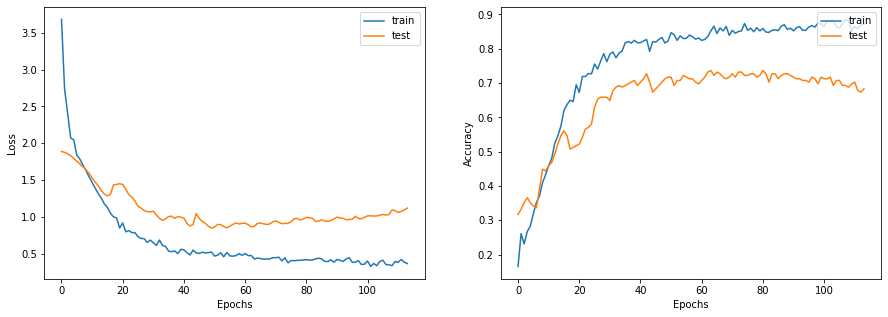

In [20]:
display_learning_curves(history)

In [21]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

42/42 [==============================] - 0s 1ms/step - loss: 0.7652 - acc: 0.7513
Test accuracy: 75.13%


In [28]:
x_train.mean(axis=0)

array([0.0021978 , 0.0029304 , 0.01172161, ..., 0.00952381, 0.01391941,
       0.0021978 ])

In [26]:
x_train.shape

(1365, 1433)

In [29]:
num_classes

7

In [30]:
class_idx

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

## Testing with a Graph Neural Network

In [31]:
# adjacency matrix
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(papers.sort_values("paper_id")[feature_names].to_numpy(),
                       dtype=tf.dtypes.float32)

# Graph = (G, V, E)
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [36]:
# Implement prepare, agregate and update for graph conv layer

class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        droupout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)
        
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize
        
        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        self.updated_fn = create_ffn(hidden_units, dropout_rate)
    
    def prepare(self, node_representations, weights=None):
        messages = self.ffn_prepare(node_representations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages
    
    def aggregate(self, node_indices, neighbour_messages):
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes)
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes)
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes)
        else:
            raise ValueError("Unsupported")
        
        return aggregated_message
    
    def update(self, node_representations, aggregated_messages):
        if self.combination_type == "concat":
            h = tf.concat([node_representations, aggregated_messages], axis=1)
        if self.combination_type == "add":
            h = node_representations + aggregated_messages
            
        node_embeddings = self.updated_fn(h)
        
        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings
    
    def call(self, inputs):
        node_representations, edges, edge_weights = inputs
        node_indices, neighbour_indices = edges[0], edges[1]
        neighbour_representations = tf.gather(node_representations, neighbour_indices)
        neighbour_messages = self.prepare(neighbour_representations, edge_weights)
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        return self.update(node_representations, aggregated_messages)

In [37]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        
        self.conv1 = GraphConvLayer(
                        hidden_units, dropout_rate, aggregation_type, combination_type, normalize,name="graph_conv1"
                    )
        
        self.conv2 = GraphConvLayer(
                        hidden_units, dropout_rate, aggregation_type, combination_type, normalize,name="graph_conv2"
                    )
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        self.compute_logits = layers.Dense(units=num_classes, name="logits")
        
    
    def call(self, input_node_indices):
        x = self.preprocess(self.node_features)
        x1 = self.conv1((x, self.edges, self.edge_weights))
        x = x1 + x
        x2 = self.conv2((x, self.edges, self.edge_weights))
        x = x2 + x
        x = self.postprocess(x)
        node_embeddings = tf.gather(x, input_node_indices)
        return self.compute_logits(node_embeddings)

In [46]:
gnn_model = GNNNodeClassifier(graph_info=graph_info,
                              num_classes=num_classes,
                              hidden_units=hidden_units,
                              dropout_rate=dropout_rate,name="gnn_model")

print("GNN output shape: ", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape:  tf.Tensor(
[[-0.10159252 -0.12972622  0.15839961  0.00142507 -0.00018834 -0.09883683
   0.11185232]
 [ 0.08740156 -0.10389881 -0.0331047   0.04814139 -0.06656429 -0.02054441
   0.14067408]
 [-0.02844257 -0.019355   -0.00748985 -0.0022977   0.00214886 -0.02946915
   0.00982921]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                           

In [47]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 3s 141ms/step - loss: 2.1887 - acc: 0.1991 - val_loss: 1.9264 - val_acc: 0.1415
Epoch 2/300
5/5 [==============================] - 0s 52ms/step - loss: 1.9941 - acc: 0.2500 - val_loss: 1.8994 - val_acc: 0.3171
Epoch 3/300
5/5 [==============================] - 0s 51ms/step - loss: 1.9040 - acc: 0.2784 - val_loss: 1.8846 - val_acc: 0.3171
Epoch 4/300
5/5 [==============================] - 0s 52ms/step - loss: 1.9021 - acc: 0.2690 - val_loss: 1.8791 - val_acc: 0.3171
Epoch 5/300
5/5 [==============================] - 0s 51ms/step - loss: 1.8822 - acc: 0.2991 - val_loss: 1.8758 - val_acc: 0.3171
Epoch 6/300
5/5 [==============================] - 0s 51ms/step - loss: 1.8557 - acc: 0.2948 - val_loss: 1.8682 - val_acc: 0.3171
Epoch 7/300
5/5 [==============================] - 0s 50ms/step - loss: 1.8484 - acc: 0.2845 - val_loss: 1.8633 - val_acc: 0.3171
Epoch 8/300
5/5 [==============================] - 0s 51ms/step - loss: 1.8398 - acc: 0.3

5/5 [==============================] - 0s 51ms/step - loss: 0.6278 - acc: 0.8095 - val_loss: 1.0088 - val_acc: 0.6878
Epoch 64/300
5/5 [==============================] - 0s 54ms/step - loss: 0.5736 - acc: 0.8164 - val_loss: 0.9683 - val_acc: 0.6976
Epoch 65/300
5/5 [==============================] - 0s 51ms/step - loss: 0.6011 - acc: 0.7948 - val_loss: 0.9806 - val_acc: 0.6829
Epoch 66/300
5/5 [==============================] - 0s 50ms/step - loss: 0.6428 - acc: 0.7905 - val_loss: 0.9779 - val_acc: 0.6927
Epoch 67/300
5/5 [==============================] - 0s 50ms/step - loss: 0.6083 - acc: 0.8017 - val_loss: 0.9886 - val_acc: 0.6878
Epoch 68/300
5/5 [==============================] - 0s 50ms/step - loss: 0.6056 - acc: 0.8086 - val_loss: 1.0282 - val_acc: 0.6878
Epoch 69/300
5/5 [==============================] - 0s 50ms/step - loss: 0.6129 - acc: 0.7940 - val_loss: 1.0456 - val_acc: 0.6732
Epoch 70/300
5/5 [==============================] - 0s 52ms/step - loss: 0.4959 - acc: 0.8379 - 

5/5 [==============================] - 0s 51ms/step - loss: 0.4211 - acc: 0.8638 - val_loss: 0.9781 - val_acc: 0.7415
Epoch 126/300
5/5 [==============================] - 0s 50ms/step - loss: 0.4403 - acc: 0.8595 - val_loss: 0.9911 - val_acc: 0.7415
Epoch 127/300
5/5 [==============================] - 0s 51ms/step - loss: 0.4125 - acc: 0.8828 - val_loss: 0.9785 - val_acc: 0.7463
Epoch 128/300
5/5 [==============================] - 0s 52ms/step - loss: 0.4417 - acc: 0.8509 - val_loss: 0.9517 - val_acc: 0.7610
Epoch 129/300
5/5 [==============================] - 0s 52ms/step - loss: 0.4312 - acc: 0.8603 - val_loss: 1.0061 - val_acc: 0.7463
Epoch 130/300
5/5 [==============================] - 0s 50ms/step - loss: 0.4084 - acc: 0.8672 - val_loss: 1.0089 - val_acc: 0.7512
Epoch 131/300
5/5 [==============================] - 0s 50ms/step - loss: 0.4039 - acc: 0.8681 - val_loss: 1.0116 - val_acc: 0.7561
Epoch 132/300
5/5 [==============================] - 0s 52ms/step - loss: 0.4148 - acc: 0.

5/5 [==============================] - 0s 49ms/step - loss: 0.3806 - acc: 0.8793 - val_loss: 0.9467 - val_acc: 0.7805
Epoch 188/300
5/5 [==============================] - 0s 50ms/step - loss: 0.3595 - acc: 0.9043 - val_loss: 0.9781 - val_acc: 0.7854
Epoch 189/300
5/5 [==============================] - 0s 51ms/step - loss: 0.3608 - acc: 0.8862 - val_loss: 0.9676 - val_acc: 0.7854
Epoch 190/300
5/5 [==============================] - 0s 50ms/step - loss: 0.3046 - acc: 0.8957 - val_loss: 0.9818 - val_acc: 0.7854
Epoch 191/300
5/5 [==============================] - 0s 50ms/step - loss: 0.3677 - acc: 0.8819 - val_loss: 0.9881 - val_acc: 0.8000
Epoch 192/300
5/5 [==============================] - 0s 49ms/step - loss: 0.3558 - acc: 0.8922 - val_loss: 0.9643 - val_acc: 0.7756
Epoch 193/300
5/5 [==============================] - 0s 50ms/step - loss: 0.3125 - acc: 0.9060 - val_loss: 0.9863 - val_acc: 0.7756
Epoch 194/300
5/5 [==============================] - 0s 51ms/step - loss: 0.3715 - acc: 0.

5/5 [==============================] - 0s 51ms/step - loss: 0.3175 - acc: 0.9034 - val_loss: 1.0903 - val_acc: 0.7561
Epoch 250/300
5/5 [==============================] - 0s 50ms/step - loss: 0.3019 - acc: 0.9026 - val_loss: 1.1432 - val_acc: 0.7610
Epoch 251/300
5/5 [==============================] - 0s 50ms/step - loss: 0.3252 - acc: 0.9052 - val_loss: 1.1268 - val_acc: 0.7610
Epoch 252/300
5/5 [==============================] - 0s 50ms/step - loss: 0.2963 - acc: 0.8983 - val_loss: 1.0647 - val_acc: 0.7707
Epoch 253/300
5/5 [==============================] - 0s 51ms/step - loss: 0.2901 - acc: 0.9095 - val_loss: 0.9938 - val_acc: 0.7854
Epoch 254/300
5/5 [==============================] - 0s 50ms/step - loss: 0.2959 - acc: 0.9034 - val_loss: 0.9574 - val_acc: 0.7805
Epoch 255/300
5/5 [==============================] - 0s 50ms/step - loss: 0.2821 - acc: 0.9155 - val_loss: 0.9200 - val_acc: 0.8000
Epoch 256/300
5/5 [==============================] - 0s 50ms/step - loss: 0.3231 - acc: 0.

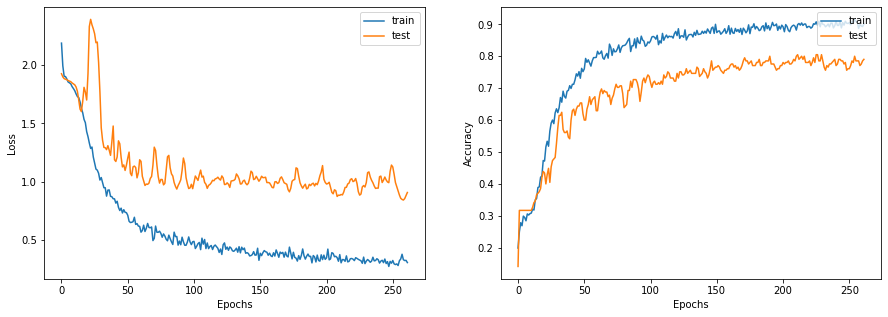

In [48]:
display_learning_curves(history)

In [49]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(test_accuracy)

0.812360405921936
